In [1]:
import torch
from neuroguard.utils.helpers import get_device

if torch.cuda.is_available():
    print("Number of GPU: ", torch.cuda.device_count())
    print("GPU Name: ", torch.cuda.get_device_name())


device = get_device()
print('Using device:', device)

Using device: mps


In [2]:
import pandas as pd
import numpy as np
import mne
import os
import matplotlib.pyplot as plt

In [3]:
from neuroguard.commons.constant import DATASETS_FOLDER
from neuroguard.data.data_loader.eeg_data_extractor import EEGDataExtractor

In [4]:
from neuroguard.utils.engine import create_user_profiles

In [5]:
from neuroguard.utils.helpers import compute_genuine_imposter_distances, compute_threshold_metrics, compute_f1_vs_threshold, split_test_data_for_verification

In [6]:
from neuroguard.utils.visualisations import plot_distance_distribution_on_ax, plot_threshold_metrics, plot_f1_vs_threshold

In [ ]:
DATA_DIR = f"{DATASETS_FOLDER}/Kolory/"

extractor = EEGDataExtractor(data_dir=DATA_DIR)
eeg_df, participants_info = extractor.extract_dataframe()

In [8]:
import torch.optim as optim
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from matplotlib.colors import ListedColormap

In [9]:
import torch.nn as nn

In [10]:
from neuroguard.data.tdnn_features import extract_features
from neuroguard.data.tdnn_dataset import TDNNDataset
from neuroguard.models.verification.xvector import XVectorEmbeddingModel
from neuroguard.losses.proxynca_loss import ProxyNCALoss
from neuroguard.utils.visualisations import plot_tsne
from neuroguard.utils.visualisations import create_handles
from neuroguard.utils.helpers import split_train_test
from neuroguard.models.similarity.centroids import SimilarityCentroidsVerifier

In [11]:
from torch.utils.tensorboard import SummaryWriter

In [12]:
from torch.optim.lr_scheduler import StepLR, ExponentialLR, ReduceLROnPlateau

In [13]:
writer = SummaryWriter(log_dir='runs/TDNN')

## Hyperparameters


In [14]:
batch_size = 64
softmax_epochs = 70 # number of pretraining epochs with softmax head
proxy_epochs = 55 # number of fine tuning epochs with proxy NCA loss
softmax_learning_rate = 0.001
softmax_learning_rate_decay = 0.95 
proxy_learning_rate = 0.001
proxy_learning_rate_decay = 0.95
augmentation = True # add gaussian noise or not
no_norm = False # weather or not skip normalization layers in  fine tuning and data generation
std = 0.02 # std of the gaussian noise, irrelevant if augmentation = False

## Feature extraction


In [15]:
X_train_tmp, X_test_tmp, y_train_tmp, y_test_tmp = split_train_test(eeg_df=eeg_df,test_size=0.2, random_state=42)

Training set participants: ['fd8a3308@1135' 'e08138e2@1731' '541c91f2@1456' '011595b1@1651'
 '2718372d@1400' '6e542bc2@0845' '2882ae26@1441' '548fd734@1628'
 '51ec2c20@0923' 'bf2d2193@1638' '022e8467@1910' '06f240e9@1215'
 'e283301e@1606' '25d0bdb3@1318' 'b34b1427@0906' 'e43a9f9f@0941'
 '8dca0725@1418' 'ffae50df@1712' '9e8bae0e@1828' '36eea4bb@1519'
 '46607ce4@1717' '54e60118@1339' '90441f44@1643' '3033b74a@1626']
Test set participants: ['f82b5699@1757' '6d9a8b86@1613' 'd87e1bd3@1806' '8bd3032e@1746'
 '39285860@1825' '446b3735@1618']
Training labels: ['011595b1@1651' '022e8467@1910' '06f240e9@1215' '25d0bdb3@1318'
 '2718372d@1400' '2882ae26@1441' '3033b74a@1626' '36eea4bb@1519'
 '46607ce4@1717' '51ec2c20@0923' '541c91f2@1456' '548fd734@1628'
 '54e60118@1339' '6e542bc2@0845' '8dca0725@1418' '90441f44@1643'
 '9e8bae0e@1828' 'b34b1427@0906' 'bf2d2193@1638' 'e08138e2@1731'
 'e283301e@1606' 'e43a9f9f@0941' 'fd8a3308@1135' 'ffae50df@1712']
Test labels: ['39285860@1825' '446b3735@1618' '6d9a8

feature extraction similar to Mel frequency cepstral coefficients


In [16]:
extracted_X_train = []
for epoch in X_train_tmp:
    extracted_X_train.append(extract_features(epoch, frame_length=50).T) 

In [17]:
extracted_X_test = []
for epoch in X_test_tmp:
    extracted_X_test.append(extract_features(epoch, frame_length=50).T)

In [18]:
le_train = LabelEncoder()
le_train.fit(y_train_tmp)
y_train_encoded = le_train.transform(y_train_tmp)

le_test = LabelEncoder()
le_test.fit(y_test_tmp)
y_test_encoded = le_test.transform(y_test_tmp)

### Standardization


In [19]:
X_train = np.array(extracted_X_train)
X_test = np.array(extracted_X_test)

In [20]:
scalers = {}
X_train_norm = np.empty_like(X_train)
X_test_norm = np.empty_like(X_test)

In [21]:
# scaling per feature
for f in range(X_train.shape[1]):
    scalers[f] = StandardScaler().fit(X_train[:, f, :])
    X_train_norm[:, f,:] = scalers[f].transform(X_train[:, f, :])
    X_test_norm[:, f, :] = scalers[f].transform(X_test[:, f, :])

### Model and dataset creation


In [22]:
num_train_classes = len(np.unique(y_train_encoded))

In [23]:
dataset = TDNNDataset(X_train_norm, y_train_encoded, augmentation=augmentation, std=std)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = XVectorEmbeddingModel(input_features=X_train_norm.shape[1],
                              num_classes=num_train_classes,
                              embedding_dim=64,
                              dropout1=0.1,
                              dropout2=0.1,
                              dropout3=0.1,
                              dropout4=0.1).to(device)
# triplet_loss_fn = nn.TripletMarginLoss(margin=0.5).to(device)
optimizer = optim.Adam(list(model.parameters()), lr=softmax_learning_rate)

In [24]:
scheduler = ExponentialLR(optimizer, gamma=softmax_learning_rate_decay)

In [25]:
criterion = nn.CrossEntropyLoss()

In [26]:
epoch_shape = np.array(X_train[0]).shape
sample_input = torch.randn(1, 1, epoch_shape[0], epoch_shape[1]).to(device).squeeze(0)

In [27]:
writer.add_graph(model, sample_input)

## Model training


Softmax pretraining stage


In [28]:
model.train()
for epoch in range(softmax_epochs):
    total_loss = 0
    total_correct = 0
    total_seen = 0
    
    for data, labels in dataloader:
        data = data.to(device)
        labels = labels.to(device).long()
        optimizer.zero_grad()
        logits = model(data)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * data.size(0)
        pred = logits.argmax(dim=1)
        total_correct += (pred == labels).sum().item()
        total_seen += data.size(0)
        
    avg_loss = total_loss / total_seen
    acc = total_correct / total_seen
    print(f"[Pretrain] Epoch {epoch+1}/{softmax_epochs}  Loss={avg_loss:.4f}  Acc={acc:.4f}")
    scheduler.step()

[Pretrain] Epoch 1/70  Loss=3.2615  Acc=0.0409
[Pretrain] Epoch 2/70  Loss=3.1168  Acc=0.0711
[Pretrain] Epoch 3/70  Loss=2.7959  Acc=0.1180
[Pretrain] Epoch 4/70  Loss=2.5294  Acc=0.1958
[Pretrain] Epoch 5/70  Loss=2.3596  Acc=0.2416
[Pretrain] Epoch 6/70  Loss=2.2413  Acc=0.2766
[Pretrain] Epoch 7/70  Loss=2.1691  Acc=0.2908
[Pretrain] Epoch 8/70  Loss=2.1113  Acc=0.3127
[Pretrain] Epoch 9/70  Loss=2.0654  Acc=0.3288
[Pretrain] Epoch 10/70  Loss=2.0408  Acc=0.3394
[Pretrain] Epoch 11/70  Loss=1.9882  Acc=0.3493
[Pretrain] Epoch 12/70  Loss=1.9597  Acc=0.3583
[Pretrain] Epoch 13/70  Loss=1.9532  Acc=0.3601
[Pretrain] Epoch 14/70  Loss=1.8829  Acc=0.3836
[Pretrain] Epoch 15/70  Loss=1.8661  Acc=0.3946
[Pretrain] Epoch 16/70  Loss=1.8292  Acc=0.4001
[Pretrain] Epoch 17/70  Loss=1.7977  Acc=0.4210
[Pretrain] Epoch 18/70  Loss=1.7884  Acc=0.4210
[Pretrain] Epoch 19/70  Loss=1.7339  Acc=0.4280
[Pretrain] Epoch 20/70  Loss=1.7303  Acc=0.4335
[Pretrain] Epoch 21/70  Loss=1.7094  Acc=0.4461
[

In [29]:
# disabling softmax
model.classifier = None

In [30]:
proxy_loss = ProxyNCALoss(num_classes=num_train_classes,
                          embedding_dim=64, scale=7).to(device)

In [31]:
optimizer = optim.Adam(list(model.parameters()) + list(proxy_loss.parameters()), lr=proxy_learning_rate) 

In [32]:
scheduler = ExponentialLR(optimizer, gamma=proxy_learning_rate_decay)

Fine-tuning with Proxy-NCA Loss


In [33]:
model.train()
for epoch in range(proxy_epochs):
    total_loss = 0
    for data, labels in dataloader:
        data, labels = data.to(device), labels.to(device).long()
        optimizer.zero_grad()
        emb = model(data, return_embedding=True, no_norm=no_norm)
        loss = proxy_loss(emb, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.size(0)
    avg_loss = total_loss / len(dataloader.dataset)
    print(f"[Fine-tune] Epoch {epoch+1}/{proxy_epochs}  Loss={avg_loss:.4f}")
    scheduler.step()

[Fine-tune] Epoch 1/55  Loss=2.4367
[Fine-tune] Epoch 2/55  Loss=1.9873
[Fine-tune] Epoch 3/55  Loss=1.8073
[Fine-tune] Epoch 4/55  Loss=1.7519
[Fine-tune] Epoch 5/55  Loss=1.6603
[Fine-tune] Epoch 6/55  Loss=1.5760
[Fine-tune] Epoch 7/55  Loss=1.5480
[Fine-tune] Epoch 8/55  Loss=1.4656
[Fine-tune] Epoch 9/55  Loss=1.4657
[Fine-tune] Epoch 10/55  Loss=1.4163
[Fine-tune] Epoch 11/55  Loss=1.3657
[Fine-tune] Epoch 12/55  Loss=1.3413
[Fine-tune] Epoch 13/55  Loss=1.3117
[Fine-tune] Epoch 14/55  Loss=1.2825
[Fine-tune] Epoch 15/55  Loss=1.2640
[Fine-tune] Epoch 16/55  Loss=1.2428
[Fine-tune] Epoch 17/55  Loss=1.2094
[Fine-tune] Epoch 18/55  Loss=1.1873
[Fine-tune] Epoch 19/55  Loss=1.1907
[Fine-tune] Epoch 20/55  Loss=1.1417
[Fine-tune] Epoch 21/55  Loss=1.1397
[Fine-tune] Epoch 22/55  Loss=1.1054
[Fine-tune] Epoch 23/55  Loss=1.0824
[Fine-tune] Epoch 24/55  Loss=1.0740
[Fine-tune] Epoch 25/55  Loss=1.0492
[Fine-tune] Epoch 26/55  Loss=1.0372
[Fine-tune] Epoch 27/55  Loss=1.0374
[Fine-tune

## Getting the embeddings and visualization


In [34]:
model.to('cpu')

XVectorEmbeddingModel(
  (relu): ReLU()
  (Frame1): Conv1d(28, 512, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (Frame2): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
  (bn2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (dropout2): Dropout(p=0.1, inplace=False)
  (Frame3): Conv1d(512, 1024, kernel_size=(3,), stride=(2,), padding=(3,), dilation=(3,))
  (bn3): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (dropout3): Dropout(p=0.1, inplace=False)
  (Frame4): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,))
  (bn4): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (dropout4): Dropout(p=0.1, inplace=False)
  (Frame5): Conv1d(1024, 1500, kernel_size=(1,), stride=(1,))
  (bn5): LayerNorm((1500,), eps=1e-05, elementwise_affine=True)
  (statPooling): StatisticsPooling()
  (embeddingLayer): Linear(in_features=3000, out_feat

In [35]:
embeddings = []

In [36]:
with torch.no_grad():
    for epoch in X_train_norm:
        embeddings.append(model(torch.tensor(epoch, dtype=torch.float, requires_grad=False).unsqueeze(0), return_embedding=True, no_norm=no_norm))

In [37]:
test_embeddings = []

In [38]:
with torch.no_grad():
    for epoch in X_test_norm:
        test_embeddings.append(model(torch.tensor(epoch, dtype=torch.float, requires_grad=False).unsqueeze(0), return_embedding=True, no_norm=no_norm))

### Visualization


In [39]:
tsne = TSNE(n_components=2, random_state=42)

In [40]:
embd = torch.stack(embeddings).reshape((X_train_norm.shape[0],64)).numpy()

In [41]:
embd_test = torch.stack(test_embeddings).reshape((X_test_norm.shape[0],64)).numpy()

In [42]:
combined_embeddings = np.concatenate((embd, embd_test), axis=0)

In [43]:
reduced_combined = tsne.fit_transform(combined_embeddings)

In [44]:
train_reduced = reduced_combined[:embd.shape[0]]
test_reduced = reduced_combined[embd.shape[0]:]

In [45]:
scaler = MinMaxScaler(feature_range=(0,1))
train_reduced_normalized = scaler.fit_transform(train_reduced)
test_reduced_normalized = scaler.transform(test_reduced)

In [46]:
custom_colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
                 '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff',
                 '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1',
                 '#000075', '#808080', '#ffffff', '#000000', '#a9a9a9', '#ff69b4',
                 '#b0e0e6', '#32cd32', '#ff4500', '#da70d6', '#ff1493', '#7fffd4']
cmap = ListedColormap(custom_colors[:30])

In [47]:
custom_colors = ['#e6194b',  # Red
                 '#3cb44b',  # Green
                 '#4363d8',  # Blue
                 '#ffe119',  # Yellow
                 '#911eb4',  # Purple
                 '#f58231']  # Orange

cmap2 = ListedColormap(custom_colors[:6])

In [48]:

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit(y_train_tmp)

In [49]:
train_handles = create_handles(y_train_tmp, cmap)
test_handles = create_handles(y_test_tmp, cmap2)

### Visualization


Good on training data - depending on training parameters clusters can be very tight or there might be some noise roughly in the middle


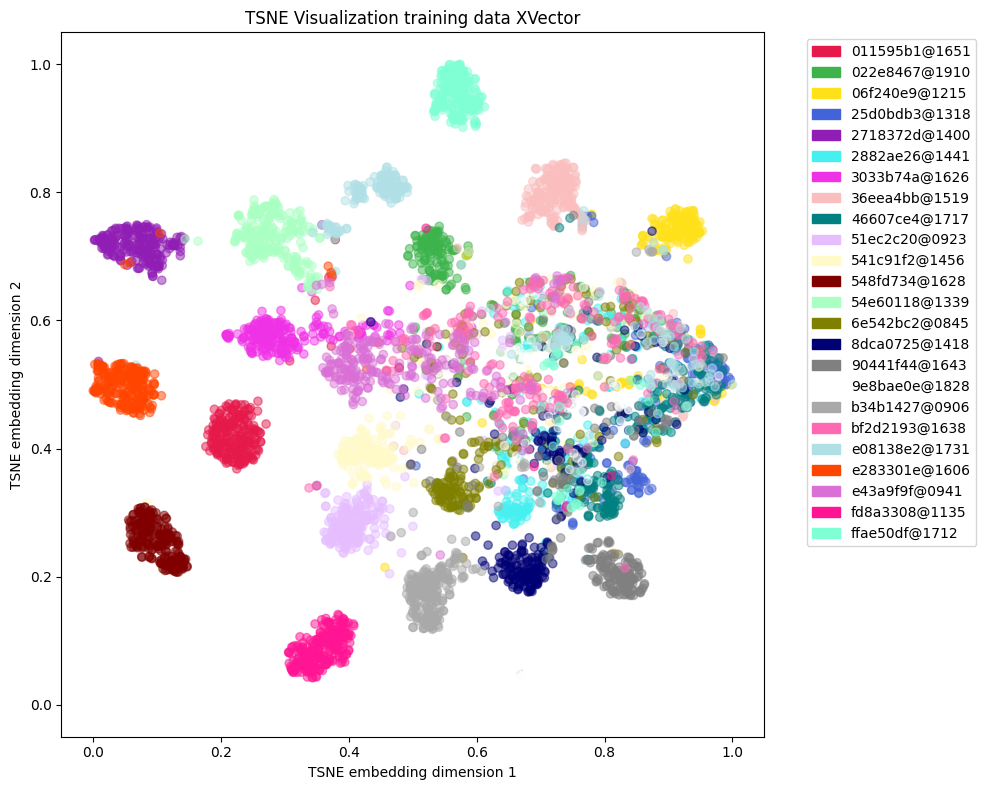

In [50]:
fig = plot_tsne(train_reduced_normalized,
          cmap,
          y_train_encoded,
          handles=train_handles,
          alpha=0.5,
          title="TSNE Visualization training data XVector",
          xlabel="TSNE embedding dimension 1",
          ylabel="TSNE embedding dimension 2",
          centroids=None,
          return_fig=True )

In [51]:
writer.add_figure('TDNN_train_TSNE', fig, global_step=0)

On test data there typically are 2 decent clusters and a significant amount of noise otherwise


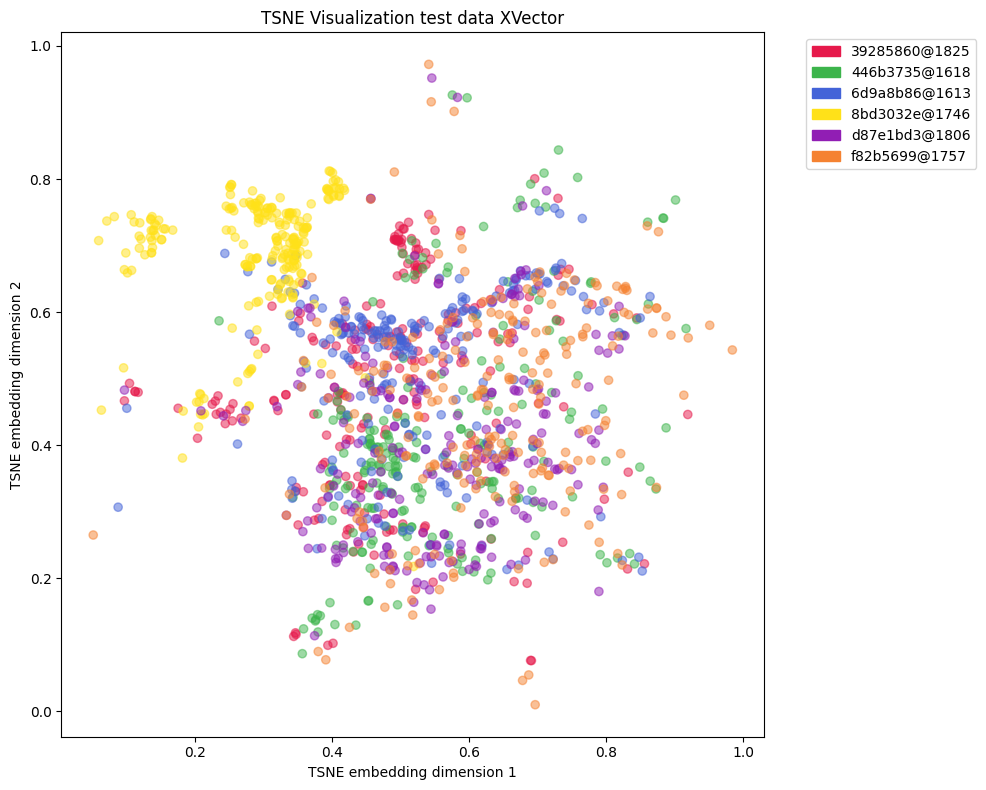

In [52]:
fig = plot_tsne(test_reduced_normalized,
          cmap2,
          y_test_encoded,
          handles=test_handles,
          alpha=0.5,
          title="TSNE Visualization test data XVector",
          xlabel="TSNE embedding dimension 1",
          ylabel="TSNE embedding dimension 2",
          centroids=None, return_fig=True )

In [53]:
writer.add_figure('TDNN_test_TSNE', fig, global_step=0)

In [54]:
writer.close()

## verification


In [55]:
scaler = MinMaxScaler(feature_range=(0,1))
train_normalized = scaler.fit_transform(embd)
test_normalized = scaler.transform(embd_test)

In [56]:
centroid_verifier_actual = SimilarityCentroidsVerifier()

In [57]:
centroid_verifier_actual.compute_true_centroids(y_train_encoded, train_normalized)

{0: array([0.46315038, 0.7093478 , 0.4278999 , 0.51581186, 0.7642746 ,
        0.6403979 , 0.62870336, 0.7824375 , 0.30761817, 0.37052238,
        0.36553043, 0.625302  , 0.40728167, 0.57690686, 0.44522128,
        0.34902287, 0.45673844, 0.36118725, 0.37310603, 0.33383125,
        0.73066175, 0.2584948 , 0.49312147, 0.20164613, 0.5791708 ,
        0.3841825 , 0.57378066, 0.3921977 , 0.33455715, 0.5818404 ,
        0.54146206, 0.636832  , 0.24184948, 0.5231591 , 0.7171503 ,
        0.6816914 , 0.41572   , 0.5050135 , 0.27595586, 0.64875907,
        0.34424058, 0.36287996, 0.50721806, 0.5060438 , 0.67228824,
        0.6537268 , 0.5024193 , 0.35853514, 0.48639646, 0.7326393 ,
        0.5267202 , 0.32396662, 0.34402022, 0.49233615, 0.57993025,
        0.18821098, 0.4220192 , 0.5109097 , 0.5879102 , 0.6167052 ,
        0.40357938, 0.45401695, 0.5819742 , 0.71333355], dtype=float32),
 1: array([0.48113   , 0.7420666 , 0.20273766, 0.53755426, 0.74035215,
        0.36696777, 0.3899973 , 0.535

In [58]:
acc = 0
for i in range(len(train_normalized)):
    true_label = y_train_encoded[i]
    predicted_label, _ = centroid_verifier_actual.classify_embedding(train_normalized[i])
    if predicted_label == true_label:
        acc += 1
acc = acc/len(train_normalized)

Training accuracy is typically between 50-80% depending on training parameters


In [59]:
acc

0.7679597701149425

In [60]:
centroid_verifier_actual_test = SimilarityCentroidsVerifier()

In [61]:
centroid_verifier_actual_test.compute_true_centroids(y_test_encoded, test_normalized)

{0: array([0.54237837, 0.6885342 , 0.29231384, 0.5046411 , 0.70061225,
        0.3795036 , 0.41891313, 0.59034365, 0.3785111 , 0.30453408,
        0.49201715, 0.64344746, 0.5768963 , 0.4854653 , 0.49376616,
        0.42535594, 0.49088725, 0.5301386 , 0.44272262, 0.5308386 ,
        0.47876078, 0.5022089 , 0.64529943, 0.42682594, 0.5885438 ,
        0.47716293, 0.6660882 , 0.42733687, 0.34817562, 0.34600037,
        0.4576414 , 0.57544374, 0.52466875, 0.40589255, 0.583867  ,
        0.48038542, 0.35678145, 0.6068174 , 0.30534622, 0.7041069 ,
        0.37312135, 0.35255456, 0.45398453, 0.5779539 , 0.47066307,
        0.28398046, 0.4479672 , 0.36713007, 0.6505203 , 0.65480095,
        0.70975417, 0.28161436, 0.3353028 , 0.495684  , 0.65269727,
        0.42392972, 0.5768996 , 0.60464716, 0.54530466, 0.58569926,
        0.49602988, 0.5068406 , 0.6219033 , 0.7000298 ], dtype=float32),
 1: array([0.5399006 , 0.7258721 , 0.351255  , 0.456996  , 0.6819456 ,
        0.3299174 , 0.42869473, 0.574

In [62]:
acc = 0
for i in range(len(test_normalized)):
    true_label = y_test_encoded[i]
    predicted_label, _ = centroid_verifier_actual_test.classify_embedding(test_normalized[i])
    if predicted_label == true_label:
        acc += 1
acc = acc/len(test_normalized)

test accuracy typically between 40-60% depending on training parameters


In [63]:
acc

0.5359195402298851

## Thresholds


Just visualizing the imposter vs genuine distributions


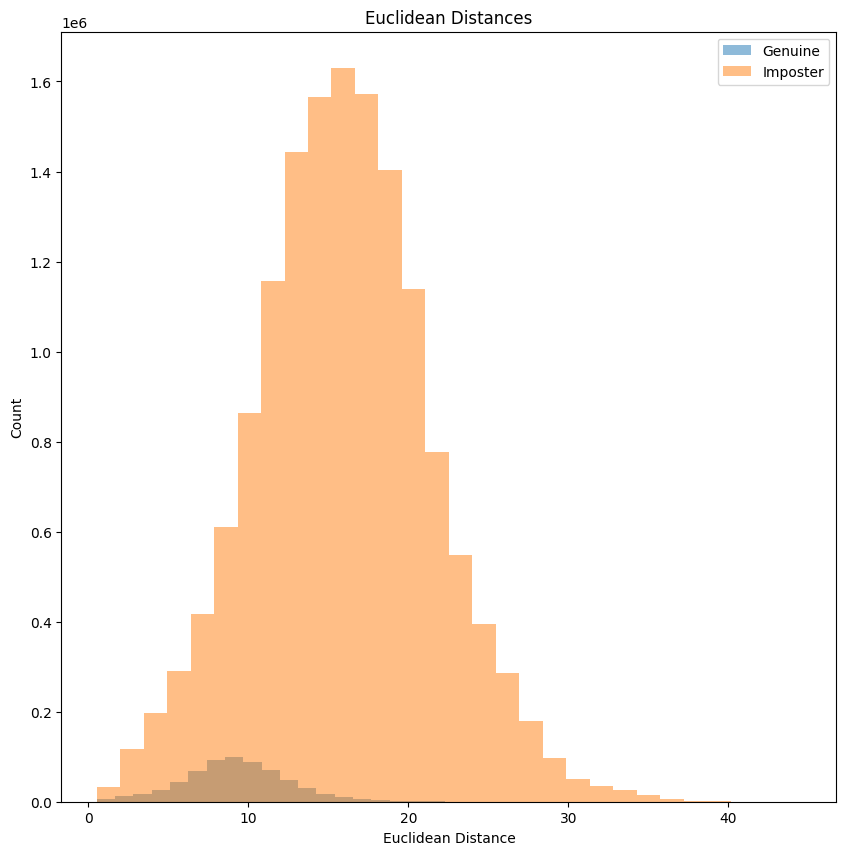

In [64]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
plot_distance_distribution_on_ax(
    embeddings=embd,
    participant_ids=np.array(y_train_encoded),
    ax=ax,
    distance_type="euclidean",
    bins=30
)

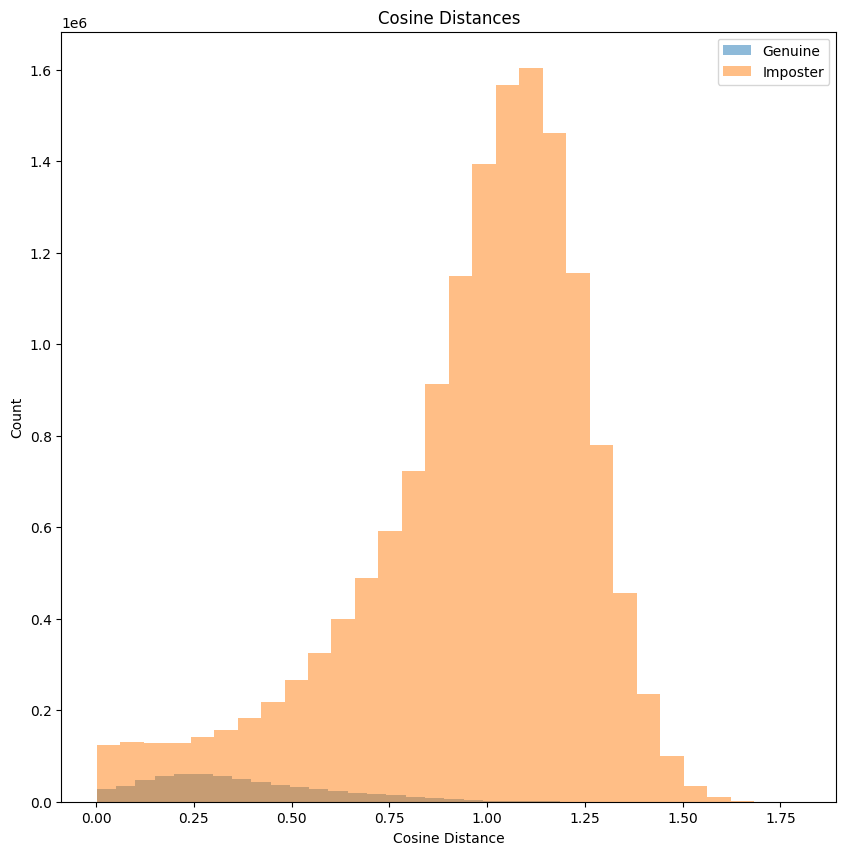

In [65]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
plot_distance_distribution_on_ax(
    embeddings=embd,
    participant_ids=np.array(y_train_encoded),
    ax=ax,
    distance_type="cosine",
    bins=30
)

Choosing threshold for training data


In [66]:
user_profiles = create_user_profiles(embd, np.array(y_train_encoded))

In [67]:
genuine_dists, imposter_dists = compute_genuine_imposter_distances(
        embeddings=embd,
        ids=np.array(y_train_encoded),
        user_profiles=user_profiles,
        distance_metric="cosine"
    )

In [68]:
(
    thresholds, fnr_list, fpr_list, acc_list,
    best_T, best_fnr, best_fpr, best_acc
) = compute_threshold_metrics(genuine_dists, imposter_dists, num_thresholds=200)

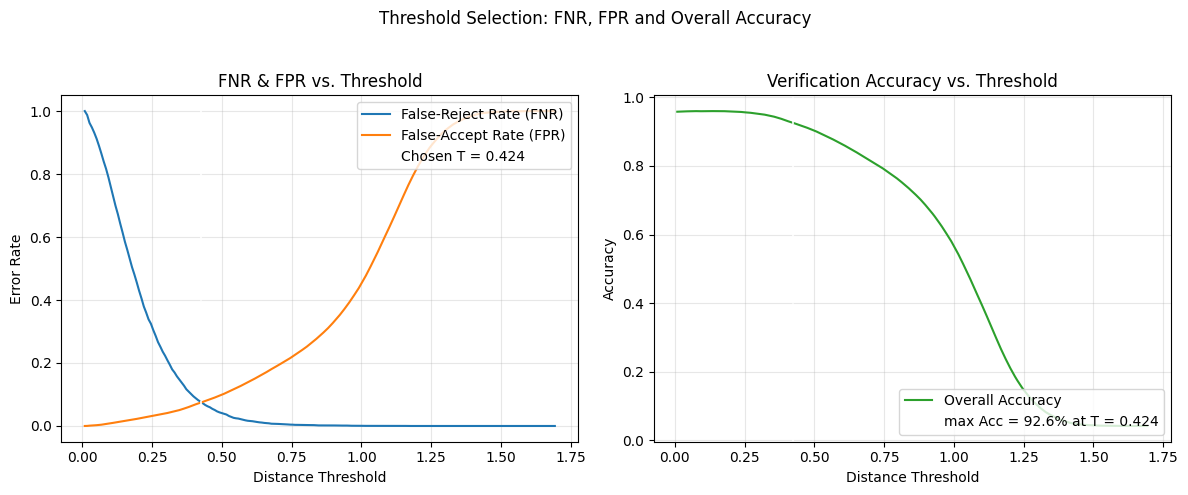

In [69]:
plot_threshold_metrics(
    thresholds, fnr_list, fpr_list, acc_list,
    best_T, best_fnr, best_fpr, best_acc
)

In [70]:
thresholds, f1_list, best_T, best_f1 = compute_f1_vs_threshold(
    genuine_dists, imposter_dists, num_thresholds=300
)

In [71]:
print(f"→ Chosen threshold = {best_T:.4f}, max F₁ = {best_f1:.3f}")

→ Chosen threshold = 0.2905, max F₁ = 0.578


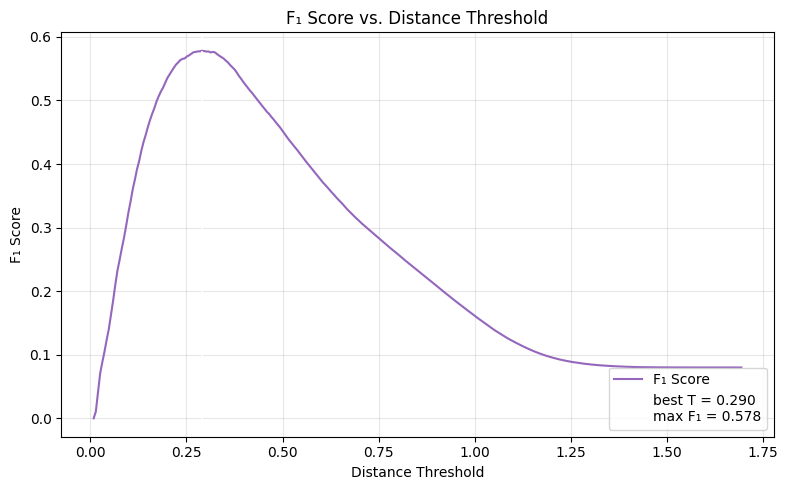

In [72]:
plot_f1_vs_threshold(thresholds, f1_list, best_T, best_f1)

For test data:

- split the test samples
- use one portion to create user profiles
- use second portion to decide the threshold


In [73]:
profile_embd, profile_ids, verify_embd, verify_ids = split_test_data_for_verification(
    embd_test, np.array(y_test_encoded), profile_ratio=0.6
)

test_user_profiles = create_user_profiles(profile_embd, profile_ids)

genuine_dists, imposter_dists = compute_genuine_imposter_distances(
    embeddings=verify_embd,
    ids=verify_ids,
    user_profiles=test_user_profiles,
    distance_metric="cosine"
)

In [74]:
(
    test_thresholds, test_fnr_list, test_fpr_list, test_acc_list,
    test_best_T, test_best_fnr, test_best_fpr, test_best_acc
) = compute_threshold_metrics(genuine_dists, imposter_dists, num_thresholds=200)

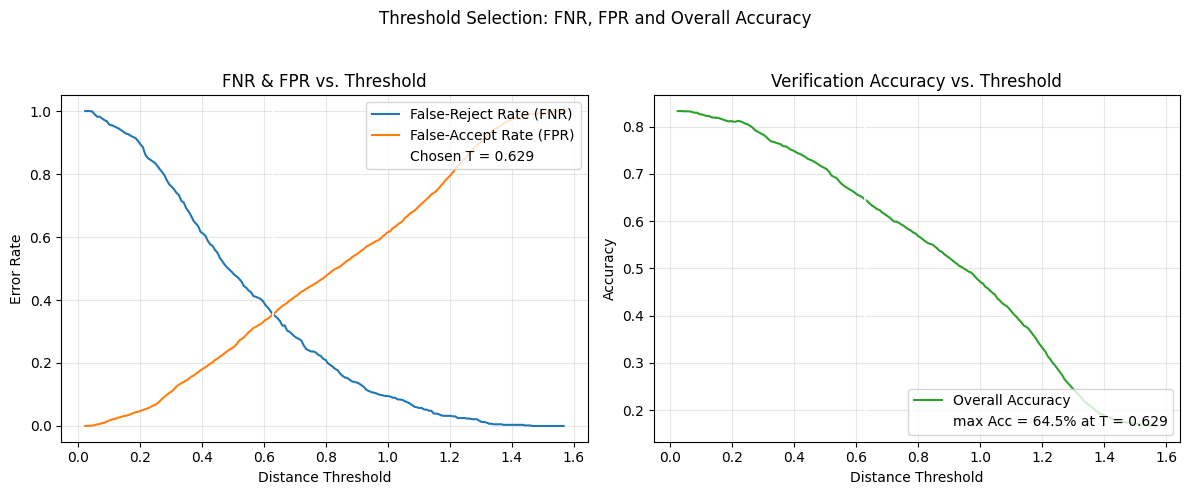

In [75]:
plot_threshold_metrics(
    test_thresholds, test_fnr_list, test_fpr_list, test_acc_list,
    test_best_T, test_best_fnr, test_best_fpr, test_best_acc
)

In [76]:
test_thresholds_f1, test_f1_list, test_best_T_f1, test_best_f1 = compute_f1_vs_threshold(
    genuine_dists, imposter_dists, num_thresholds=300
)

print(f"→ Test Data F1: Chosen threshold = {test_best_T_f1:.4f}, max F₁ = {test_best_f1:.3f}")

→ Test Data F1: Chosen threshold = 0.7466, max F₁ = 0.384


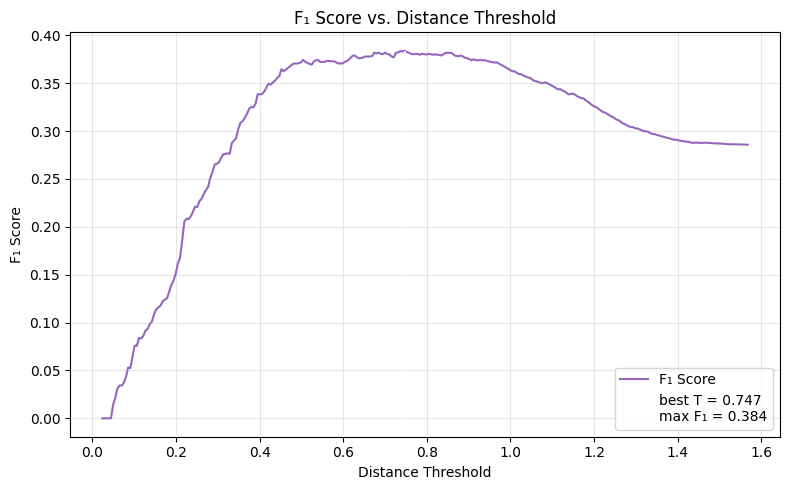

In [77]:
plot_f1_vs_threshold(test_thresholds_f1, test_f1_list, test_best_T_f1, test_best_f1)